In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.rc = {'figure.dpi': 400, 'savefig.dpi': 300, \
                            'font.size': 12, \
                            'figure.facecolor': (1, 1, 1, 0)}

In [2]:
trips = pd.read_csv('mrt_trips_sampled.csv', index_col='index')
trips.head()

,destination,destination_tm,origin,origin_tm
index,,,,
0,Bugis DTL,10:04:47,Stevens,9:52:23
1,Kent Ridge,10:11:34,Sengkang,9:27:41
2,Tai Seng,9:35:59,Compassvale,9:03:44
3,Labrador Park,9:45:50,Bishan NSEW,9:14:45
4,Joo Koon,9:27:32,Boon Lay,9:20:36


In [3]:
trips.describe()

,destination,destination_tm,origin,origin_tm
count,381249,381249,381249,381249
unique,153,7002,154,3600
top,Raffles Place,9:45:29,Ang Mo Kio,9:03:51
freq,22938,189,11898,213


In [4]:
# remove things like NSEW or CCL at the end
import re
regex = r"(\s[A-Z]{2}[A-Z]*)"
pattern = re.compile(regex)
def strip_line_name(x):
    matches = pattern.findall(x)
    if not matches:
        return x.strip()
    else:
        return x.replace(matches[0], '').strip()

trips.destination = trips.destination.apply(strip_line_name)
trips.origin = trips.origin.apply(strip_line_name)

# swap origin and destination if not sorted since we assume A-B takes the same time as B-A
sorted_od = trips[['origin', 'destination']].apply(np.sort, axis=1)
trips.origin = sorted_od.origin
trips.destination = sorted_od.destination

In [5]:
trips['destination_tm'] = pd.to_datetime(trips.destination_tm, format='%H:%M:%S')
trips['origin_tm'] = pd.to_datetime(trips.origin_tm, format='%H:%M:%S')
trips['duration'] = (trips.destination_tm - trips.origin_tm).dt.seconds
trips.drop(['destination_tm', 'origin_tm'], axis=1, inplace=True)
trips.head()

,destination,origin,duration
index,,,
0,Stevens,Bugis,744
1,Sengkang,Kent Ridge,2633
2,Tai Seng,Compassvale,1935
3,Labrador Park,Bishan,1865
4,Joo Koon,Boon Lay,416


In [6]:
origin_dest = trips.groupby(['origin', 'destination']).agg({'duration': ['median', 'count']}).reset_index()
origin_dest.columns = list(map(''.join, origin_dest.columns.values))  # flatten multiindex
origin_dest.columns = ['origin', 'destination', 'duration', 'trips_count']
trips = origin_dest[(origin_dest.duration < 2*3600) & (origin_dest.duration > 30.)]
dropped = origin_dest[(origin_dest.trips_count <= 4) & (origin_dest.duration < 2*3600) & (origin_dest.duration > 30.)]
trips = (trips[trips.origin != trips.destination]).sort_values(['duration', 'origin', 'destination']).drop(['trips_count'], axis=1).reset_index(drop=True)

In [7]:
# dropped[dropped.duration < 1000]

In [8]:
trips.duration = trips.duration - 60
trips = (trips[trips.duration > 30.]).reset_index()

In [9]:
from collections import defaultdict
cost = defaultdict(dict)
stations = list(set(list(trips.destination.unique()) + list(trips.origin.unique())))
for index, row in trips.iterrows():
    cost[row.origin][row.destination] = row.duration
    cost[row.destination][row.origin] = row.duration

In [10]:
# Mountbatten ['Dakota', 'Stadium', 'Nicoll Highway']
cost['Mountbatten']['Dakota']

142.0

In [11]:
len(stations)

138

In [12]:
is_adjacent_flags = np.ones(len(trips.index))
for index, row in trips.iterrows():
    for station in stations:
        if cost[row.origin].get(station, float('inf')) + cost[station].get(row.destination, float('inf')) < row.duration + 120:
            is_adjacent_flags[index] = 0
            break

In [13]:
new_trips = trips
new_trips['adjacent'] = is_adjacent_flags
graph = nx.from_pandas_dataframe(new_trips[new_trips.adjacent == 1], 'origin', 'destination')

In [14]:
len(graph.edges())

521

In [15]:
from collections import defaultdict
adj_list = defaultdict(list)
for edge in graph.edges():
    adj_list[edge[0]].append(edge[1])
    adj_list[edge[1]].append(edge[0])

adj_list['Admiralty']

['Coral Edge', 'Yishun', 'Woodlands', 'Sembawang', 'Segar']

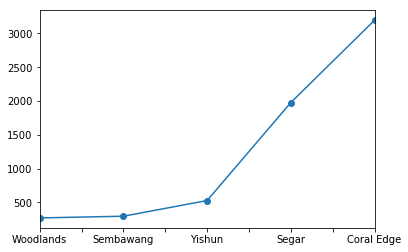

In [16]:
distances = [(cost['Admiralty'][stn], stn) for stn in adj_list['Admiralty']]
distances.sort()
d = np.array([x[0] for x in distances])
x = np.array([x[1] for x in distances])
pd.Series(d, index=x).plot(style='o-')

In [17]:
new_adj_list = adj_list.copy()
for k, v in adj_list.items():
    distances = [(cost[k][stn], stn) for stn in v]
    distances.sort()
    d = np.array([x[0] for x in distances])
    steps = np.diff(d)
    
    break_index = None
    for i, step in enumerate(steps):
        if step > 3*60:
            break_index = i+1
            break
    for i, dis in enumerate(d):
        if dis > 20*60:  # remove if distance more than 20 minutes
            if break_index:
                break_index = min(break_index, i)
            else:
                break_index = i
            break
    if not break_index:
        continue

    distances = distances[:break_index]
    stns = [x[1] for x in distances]
    new_adj_list[k] = stns

In [18]:
for k, v in new_adj_list.items():
    print(k, v)

Dakota ['Mountbatten', 'Paya Lebar', 'MacPherson']
Mountbatten ['Dakota', 'Stadium', 'Nicoll Highway']
Paya Lebar ['Eunos', 'Aljunied', 'MacPherson', 'Dakota', 'Kallang', 'Bartley', 'Lavender']
MacPherson ['Tai Seng', 'Paya Lebar', 'Dakota']
Soo Teck ['Cove']
Kranji ['Marsiling', 'Yew Tee', 'Woodlands']
Stadium ['Mountbatten', 'Nicoll Highway', 'Promenade']
Nicoll Highway ['Promenade', 'Stadium', 'Mountbatten', 'Esplanade', 'Bayfront', 'Dhoby Ghaut', 'Marina Bay']
Braddell ['Toa Payoh', 'Bishan']
Cove ['Meridian']
Meridian ['Cove', 'Coral Edge', 'Oasis']
Punggol ['Damai', 'Sengkang', 'Sam Kee', 'Cove', 'Coral Edge']
Kadaloor ['Oasis', 'Riviera', 'Damai', 'Coral Edge', 'Cove']
Damai ['Oasis', 'Kadaloor', 'Punggol', 'Cove']
Nibong ['Cove', 'Soo Teck', 'Punggol', 'Sengkang', 'Buangkok']
Kovan ['Hougang', 'Serangoon', 'Woodleigh']
Rochor ['Little India', 'Promenade', 'Bugis', 'Newton', 'Stevens', 'Bayfront', 'Downtown']
Buona Vista ['Holland Village', 'one-north', 'Commonwealth', 'Dover', 

In [19]:
g = nx.Graph()
for k, v in new_adj_list.items():
    for stn in v:
        g.add_edge(k, stn)

In [20]:
# remove loops with 3 stops
for i in g.nodes():
    for j in g.nodes():
        for k in g.nodes():
            if i == j or j == k or i == k:
                continue
            if not (g.has_edge(i, j) and g.has_edge(j, k), g.has_edge(i, k)):
                continue
            d = {0: (i, j), 1: (j, k), 2: (i, k)}
            try:
                costs = [cost[i][j], cost[j][k], cost[i][k]]
            except KeyError:
                continue
            largest_index = np.argmax(costs)
            edge1, edge2 = d[largest_index]
            if g.has_edge(edge1, edge2):
                g.remove_edge(edge1, edge2)

In [21]:
g = nx.convert_node_labels_to_integers(g, label_attribute='name')

In [22]:
from networkx.readwrite import json_graph
import json
data = json_graph.node_link_data(g)
with open('mrt.json', 'w') as f:
    json.dump(data, f, indent=2)